In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
# Definir o ticker do Bitcoin
btc = yf.Ticker("BTC-USD")

# Obter dados históricos (desde 2014)
data = btc.history(start="2014-01-01", end=pd.to_datetime('today').strftime('%Y-%m-%d'))

# Visualizar as primeiras linhas
data.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0


In [3]:
# Resumo estatístico
data['Close'].describe()


count     3665.000000
mean     17958.809922
std      19757.089793
min        178.102997
25%       1169.280029
50%       9182.577148
75%      29283.103516
max      73083.500000
Name: Close, dtype: float64

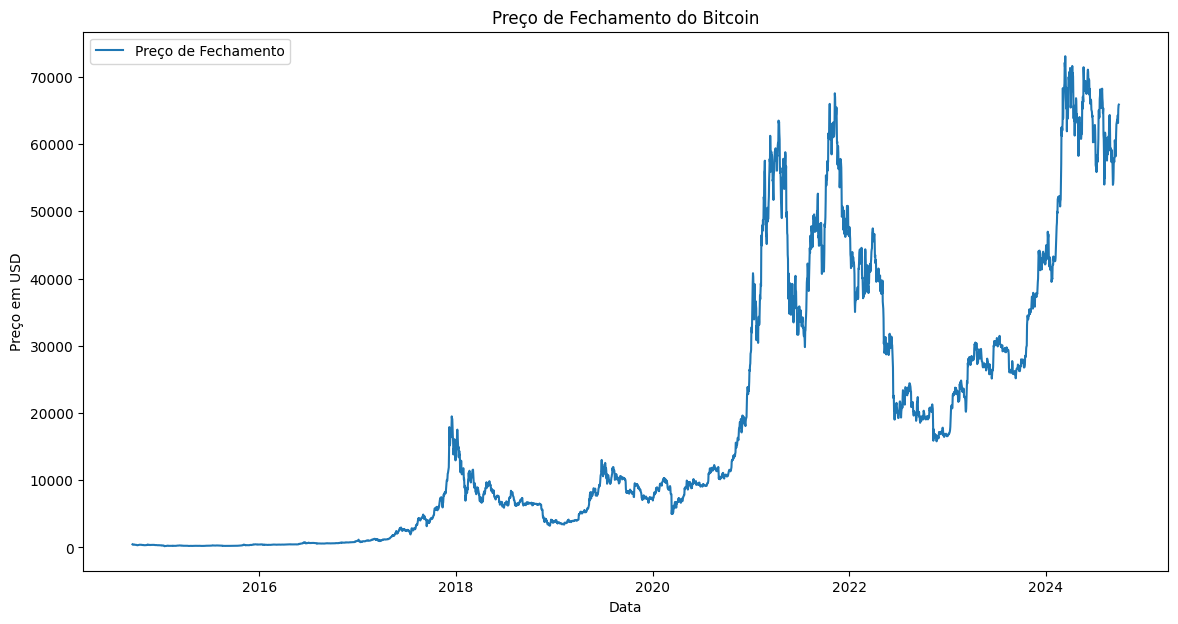

In [4]:
# Plotar o preço de fechamento
plt.figure(figsize=(14,7))
plt.plot(data.index, data['Close'], label='Preço de Fechamento')
plt.title('Preço de Fechamento do Bitcoin')
plt.xlabel('Data')
plt.ylabel('Preço em USD')
plt.legend()
plt.show()


## COMECO PREPARAÇÃO DADOS DO MODELO

## LSTM

2024-09-29 18:32:14.166482: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-29 18:32:14.166946: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-29 18:32:14.168810: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-29 18:32:14.174541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 18:32:14.183939: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0071 - val_loss: 0.0157
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0047 - val_loss: 0.0020
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 6.0861e-04 - val_loss: 0.0070
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.9019e-04 - val_loss: 0.0016
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 6.9341e-04 - val_loss: 0.0033
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 9.6659e-04 - val_loss: 0.0031
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0014 - val_loss: 0.0088
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0017 - val_loss: 0.0026
Epoch 12/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/

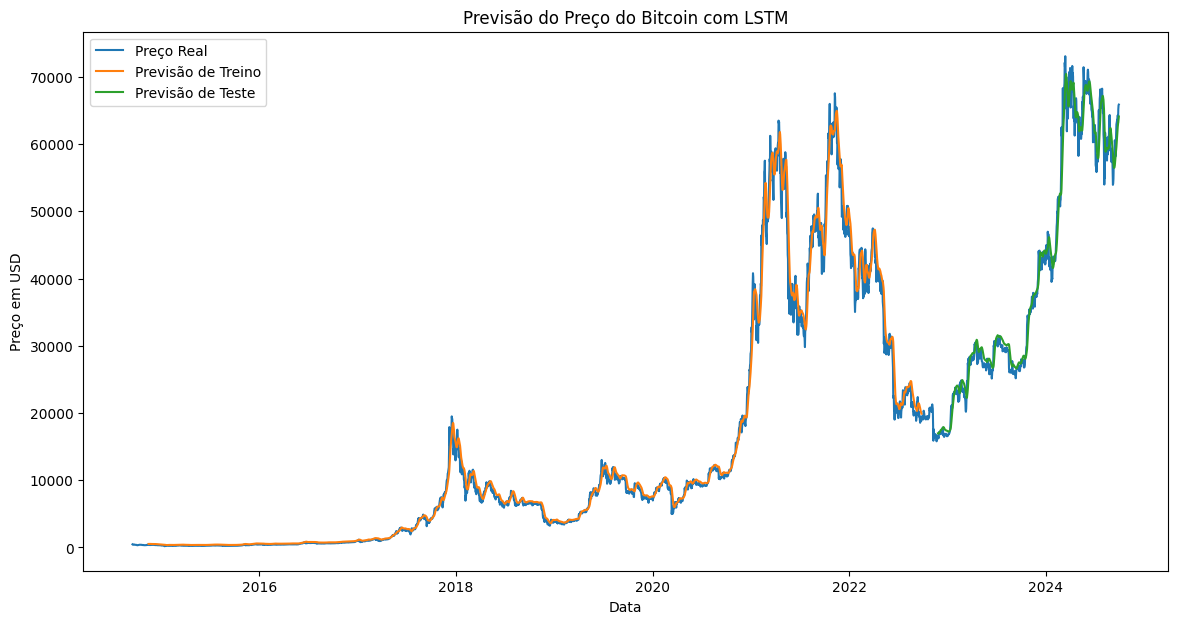

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings("ignore")

# Coleta dos dados do Bitcoin
btc = yf.Ticker("BTC-USD")
data = btc.history(start="2014-01-01", end=pd.to_datetime('today').strftime('%Y-%m-%d'))

# Seleção da coluna 'Close' e preparação dos dados
df = data[['Close']].reset_index()
dataset = df['Close'].values.reshape(-1, 1)

# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

# Divisão em conjuntos de treino e teste usando train_test_split
train_data, test_data = train_test_split(scaled_data, test_size=0.2, shuffle=False)

# Parâmetro look_back
look_back = 60  # Número de passos de tempo anteriores usados para prever o próximo valor

# Usando TimeseriesGenerator para criar os conjuntos de dados para o LSTM
train_generator = TimeseriesGenerator(train_data, train_data, length=look_back, batch_size=64)
test_generator = TimeseriesGenerator(test_data, test_data, length=look_back, batch_size=64)

# Construção do modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

# Compilação do modelo
model.compile(loss='mean_squared_error', optimizer='adam')

# Treinamento do modelo
model.fit(train_generator, epochs=20, validation_data=test_generator, verbose=1)

# Fazer previsões
train_predict = model.predict(train_generator)
test_predict = model.predict(test_generator)

# Obter os valores reais correspondentes
y_train_actual = train_data[look_back:]
y_test_actual = test_data[look_back:]

# Inverter a normalização
train_predict = scaler.inverse_transform(train_predict)
y_train_actual = scaler.inverse_transform(y_train_actual)

test_predict = scaler.inverse_transform(test_predict)
y_test_actual = scaler.inverse_transform(y_test_actual)

# Calcular RMSE
train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predict))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# Preparar as datas para plotagem
train_dates = df['Date'][look_back:len(train_predict)+look_back]
test_dates = df['Date'][len(train_data)+look_back:len(scaled_data)]

# Plotar previsões vs dados reais
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], scaler.inverse_transform(scaled_data), label='Preço Real')
plt.plot(train_dates, train_predict, label='Previsão de Treino')
plt.plot(test_dates, test_predict, label='Previsão de Teste')
plt.title('Previsão do Preço do Bitcoin com LSTM')
plt.xlabel('Data')
plt.ylabel('Preço em USD')
plt.legend()
plt.show()